In [ ]:
# since most configuration are very similar, this notebook is used to run different configuration by override a few parameters

In [44]:
# set the current working directory
import os
os.chdir('/Users/cgu3/Documents/Grape-Pi')

# Sensitivity analysis

For the sensitivity analysis to test using interaction with difference confidence threshold:150 (low), 400 (medium), 700 (high), and 0.9 (highest)
with different layer_type: GCNConv and SAGEConv
different column: protein_probability and combined_score

In [50]:
!python main.py  --config-path configs/protein --config-name grapepi_gcnconv

Rebuilding...
Done!
GCNConvGymModule(
  (model): GNN(
    (encoder): FeatureEncoder()
    (pre_mp): GeneralMultiLayer(
      (Layer_0): GeneralLayer(
        (layer): Linear(
          (model): Linear(-1, 10, bias=True)
        )
        (post_layer): Sequential(
          (0): Dropout(p=0.3, inplace=False)
          (1): ReLU()
        )
      )
    )
    (mp): GNNStackStage(
      (layer0): GeneralLayer(
        (layer): GCNConv(
          (model): GCNConv(10, 10)
        )
        (post_layer): Sequential(
          (0): Dropout(p=0.3, inplace=False)
          (1): ReLU()
        )
      )
    )
    (post_mp): ExampleNodeHead(
      (layer_post_mp): MLP(
        (model): Sequential(
          (0): Linear(
            (model): Linear(10, 1, bias=True)
          )
        )
      )
    )
  )
)
accelerator: cpu
benchmark: False
bn:
  eps: 1e-05
  mom: 0.1
cfg_dest: config.yaml
custom_metrics: []
dataset:
  cache_load: False
  cache_save: False
  dir: data/gastric_all_data
  edge_dim: 1

In [74]:
confidence_threshold = [150.0, 400.0, 700.0, 900.0]
layer_type = ['grapepi_gcnconv', 'grapepi_sageconv']

# create a list of configurations
configs = []
for threshold in confidence_threshold:
    for layer in layer_type:
        config = f'{layer}_thresh_{threshold}'
        configs.append(config)

configs

['grapepi_gcnconv_thresh_150.0',
 'grapepi_sageconv_thresh_150.0',
 'grapepi_gcnconv_thresh_400.0',
 'grapepi_sageconv_thresh_400.0',
 'grapepi_gcnconv_thresh_700.0',
 'grapepi_sageconv_thresh_700.0',
 'grapepi_gcnconv_thresh_900.0',
 'grapepi_sageconv_thresh_900.0']

In [75]:
import os
import pandas as pd
import json

# Initialize an empty list to store the data
data_list = []

# Loop through each folder and read the JSON file
for folder in configs:
    file_path = os.path.join('results', folder, '1234', 'test', 'stats.json')
    with open(file_path, 'r') as file:
        data = json.loads(file.read())
        data['folder'] = folder  # Add the folder name as a new column
        data_list.append(data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display the DataFrame
print(df)

   epoch    loss     lr  params  time_iter  accuracy  precision  recall  \
0    300  0.6166  0.001     141     4.7883    0.8154     0.7030  0.8741   
1    110  0.4822  0.001     241     4.5382    0.8480     0.8004  0.7719   
2    300  0.6169  0.001     141     4.4994    0.8142     0.7076  0.8549   
3    146  0.4795  0.001     241     4.5797    0.8441     0.7942  0.7676   
4    300  0.6330  0.001     141     4.3650    0.7975     0.6904  0.8282   
5    131  0.4991  0.001     241     4.5139    0.8281     0.7594  0.7676   
6    300  0.6367  0.001     141     4.7825    0.7908     0.6761  0.8420   
7    161  0.4755  0.001     241     4.6228    0.8374     0.7825  0.7622   

       f1     auc                         folder  
0  0.7793  0.9150   grapepi_gcnconv_thresh_150.0  
1  0.7859  0.9009  grapepi_sageconv_thresh_150.0  
2  0.7743  0.9016   grapepi_gcnconv_thresh_400.0  
3  0.7806  0.9028  grapepi_sageconv_thresh_400.0  
4  0.7530  0.8864   grapepi_gcnconv_thresh_700.0  
5  0.7634  0.8965 

In [76]:
df[['layer_type', 'threshold']] = df['folder'].str.extract(r'grapepi_(gcnconv|sageconv)_thresh_(\d{3,4})')

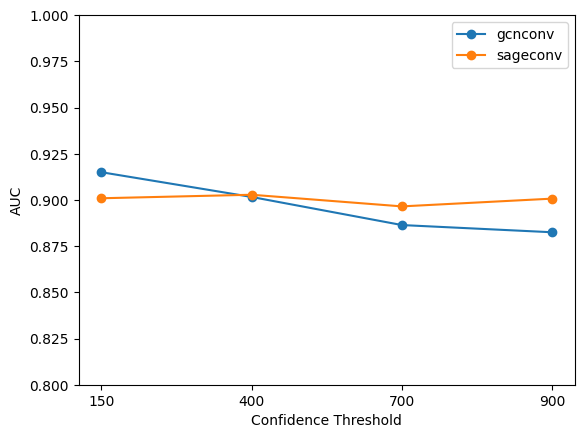

In [78]:
# plot with threshold at x-axis and layer_type as group by color. AUC as value in y-axis
import matplotlib.pyplot as plt
# plot
fig, ax = plt.subplots()
for layer, group in df.groupby('layer_type'):
    ax.plot(group['threshold'], group['auc'], marker='o', label=layer)
# change y-axis range
ax.set_ylim(0.8, 1)
# set x-axis label
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('AUC')
ax.legend()
plt.show()



# Sensitivity analysis for different criterion for labeling

Testing case with different label column: hard_label_02_08, hard_label_03_07, and hard_label_04_06 under medium confidence threshold with SAGEConv, GCNConv, and MLP model. In total 9 different configurations

In [81]:
import pandas as pd

dat = pd.read_csv('data/gastric_all_data/raw/protein/gastric_all_data.csv')
dat

,protein,protein_probability,mRNA,y
0,YNR077C,0.00,0.13,0
1,YDR444W,0.96,0.15,0
2,YHR213W,0.00,0.16,0
3,YLR465C,0.00,0.16,0
4,YDR543C,0.00,0.18,0
...,...,...,...,...
3204,YKL152C,1.00,122.05,1
3205,YDL184C,0.00,125.56,0
3206,YLR044C,1.00,138.72,1
3207,YKL060C,1.00,153.36,1


In [82]:
from sklearn.metrics import roc_auc_score

for hard_label in ['hard_label_04_06', 'hard_label_03_07', 'hard_label_02_08']:
    labeled = ~dat[hard_label].isnull()
    raw = dat[hard_label][labeled]
    true = dat['protein_probability'][labeled]
    # calcualte AUC between raw and true
    auc = round(roc_auc_score(raw, true), 3)
    print(auc)

KeyError: 'hard_label_04_06'

In [67]:
import os
import pandas as pd
import json

# List of data folders
data_folders = [
    'grapepi_sageconv_label_hard_label_04_06',
    'grapepi_sageconv_label_hard_label_03_07',
    'grapepi_sageconv_label_hard_label_02_08',
    'grapepi_gcnconv_label_hard_label_04_06',
    'grapepi_gcnconv_label_hard_label_03_07',
    'grapepi_gcnconv_label_hard_label_02_08'
]

# Initialize an empty list to store the data
data_list = []

# Loop through each folder and read the JSON file
for folder in data_folders:
    file_path = os.path.join('results', folder, '1234', 'test', 'stats.json')
    with open(file_path, 'r') as file:
        data = json.loads(file.read())
        data['folder'] = folder  # Add the folder name as a new column
        data_list.append(data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display the DataFrame
print(df)

   epoch    loss     lr  params  time_iter  accuracy  precision  recall  \
0    173  0.5751  0.001     241     4.4501    0.7960     0.6896  0.7333   
1    110  0.4822  0.001     241     4.6558    0.8480     0.8004  0.7719   
2    167  0.3588  0.001     241     4.6731    0.8851     0.8702  0.8405   
3    300  0.6812  0.001     141     4.7386    0.7743     0.6436  0.8316   
4    300  0.6166  0.001     141     4.7972    0.8154     0.7030  0.8741   
5    300  0.5357  0.001     141     4.6169    0.8438     0.7644  0.9093   

       f1     auc                                   folder  
0  0.7108  0.8649  grapepi_sageconv_label_hard_label_04_06  
1  0.7859  0.9009  grapepi_sageconv_label_hard_label_03_07  
2  0.8551  0.9307  grapepi_sageconv_label_hard_label_02_08  
3  0.7257  0.8754   grapepi_gcnconv_label_hard_label_04_06  
4  0.7793  0.9150   grapepi_gcnconv_label_hard_label_03_07  
5  0.8306  0.9406   grapepi_gcnconv_label_hard_label_02_08  


In [69]:
import numpy as np
df[['conv_type', 'label']] = df['folder'].str.extract(r'grapepi_(sageconv|gcnconv)_label_(hard_label_\d{2}_\d{2})')
df

,epoch,loss,lr,params,time_iter,accuracy,precision,recall,f1,auc,folder,conv_type,label
0,173,0.5751,0.001,241,4.4501,0.7960,0.6896,0.7333,0.7108,0.8649,grapepi_sageconv_label_hard_label_04_06,sageconv,hard_label_04_06
1,110,0.4822,0.001,241,4.6558,0.8480,0.8004,0.7719,0.7859,0.9009,grapepi_sageconv_label_hard_label_03_07,sageconv,hard_label_03_07
2,167,0.3588,0.001,241,4.6731,0.8851,0.8702,0.8405,0.8551,0.9307,grapepi_sageconv_label_hard_label_02_08,sageconv,hard_label_02_08
3,300,0.6812,0.001,141,4.7386,0.7743,0.6436,0.8316,0.7257,0.8754,grapepi_gcnconv_label_hard_label_04_06,gcnconv,hard_label_04_06
4,300,0.6166,0.001,141,4.7972,0.8154,0.7030,0.8741,0.7793,0.9150,grapepi_gcnconv_label_hard_label_03_07,gcnconv,hard_label_03_07
5,300,0.5357,0.001,141,4.6169,0.8438,0.7644,0.9093,0.8306,0.9406,grapepi_gcnconv_label_hard_label_02_08,gcnconv,hard_label_02_08


In [70]:
# add a new column with auc 0.846, label_08, conv_type='raw'
row1 = {'auc': 0.797, 'label': 'hard_label_04_06', 'conv_type':'raw'}
row2 = {'auc':0.846, 'label': 'hard_label_02_08', 'conv_type': "raw"}
row3 = {'auc': 0.821, 'label': 'hard_label_03_07', 'conv_type': "raw"}

new_rows = pd.DataFrame([row1, row2, row3])
df = pd.concat([df, new_rows], ignore_index=True)

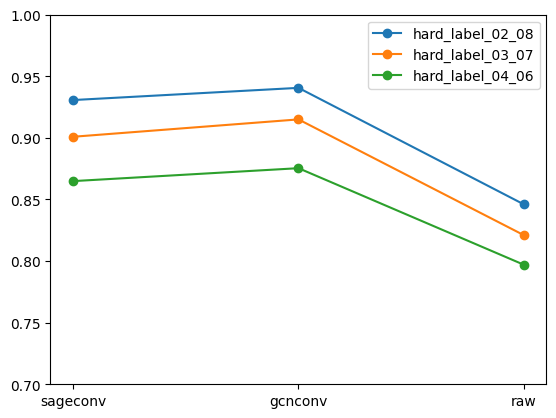

In [73]:
import matplotlib.pyplot as plt
# plot
fig, ax = plt.subplots()
for label, group in df.groupby('label'):
    ax.plot(group['conv_type'], group['auc'], marker='o', label=label)
ax.set_ylim(0.7, 1)
ax.legend()
plt.show()


# Calculate auc from raw data for yeast

In [83]:
from grape_pi import ProteinDataset

In [95]:
dataset_yeast_LCQ = ProteinDataset('data/yeast-LCQ', node_numeric_cols=['protein_probability'], rebuild=True)
dataset_yeast_ORBI = ProteinDataset('data/yeast-ORBI', node_numeric_cols=['protein_probability'], rebuild=True)

Rebuilding...
Done!
Rebuilding...
Done!


In [101]:
auc_yeast_LCQ = roc_auc_score(dataset_yeast_LCQ._data.y, dataset_yeast_LCQ._data.x)
auc_yeast_ORBI = roc_auc_score(dataset_yeast_ORBI._data.y, dataset_yeast_ORBI._data.x)
print("AUC for yeast-LCQ: ", auc_yeast_LCQ)
print("AUC for yeast-ORBI: ", auc_yeast_ORBI)

AUC for yeast-LCQ:  0.6256950862236975
AUC for yeast-ORBI:  0.8361260553994329
